# Thème 3: Aménagement cyclable/apaisement
**Correspondance cartographique :** densité point rouge_58 / vert_60 x type de voirie (Données Route 500) 
- Identifier la part des points rouges situées à moins de 50 mètres de voies / carrefours routières 
- La majorité des points rouges se situe sur des infrastructures routières complexes (voies structurantes / carrefour routier) 

> Hypothèse : Il faut transformer les infrastructures automobiles structurantes pour sécuriser la pratique des cyclistes

**Consignes supplémentaires :** Initialement l'idée était de faire ça avec les points uniques mais faire cela à partir des concentrations de points que tu as identifié sera sans doute plus pertinent.<br/>

identifier pour chaque cluster (vert / rouge) :
1. sur quels types de voirie il se situe (oui ou non présent sur un gros axe)
2. Et voir s'il y a une corrélation 

(on retrouve un lien entre cluster rouge & liaison à vocation régionale/nationale là où on a des infra de route les plus importantes les points les plus dangereux car ce n'est pas adaptée)
!= points verts --> liaisons locales (car c'est aménagés)


NB_VOIES --> danger car voie trop grande ??? 


Livrable : tableau + graphique + correlation ou pas

Cluster contient un carrefour ? --> typologie du carrefour lien entre la présence d'un carrefour et la présence d'un cluster ? 

## Python stuff

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from s3_utils import S3Manager
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact

# Configs
_ = plt.style.use("ggplot")

In [2]:
s3_manager = S3Manager()
bucket = "fub-s3"

## 1 - Récupération et préparation des données

### 1.1 - Clusters en entrée

In [3]:
gdf_58 = gpd.read_file("temp/cluster_cat_58.geojson")
gdf_60 = gpd.read_file("temp/cluster_cat_60.geojson")

In [4]:
# Infos rapides sur les datasets 
print(gdf_58.crs if gdf_60.crs == gdf_58.crs else "Les CRS sont différents uniformiser les données")
gdf_58.head(3)

EPSG:4326


,cluster_id,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points,geometry
0,0,261dbaa4-2555-40b2-a627-cb7c0d947172,58,d9bfec3d-fef7-47c9-b949-60964467556f,,92049,Montrouge,89,554,16.06,"POLYGON ((2.31115 48.8156, 2.31105 48.81604, 2..."
1,1,8489e10a-8434-4d03-8161-a0606c67f44b,58,d9bfec3d-fef7-47c9-b949-60964467556f,,92049,Montrouge,109,554,19.68,"POLYGON ((2.31914 48.81765, 2.3185 48.8187, 2...."
2,2,8f6e0b77-2819-435e-a910-ceb2905e89ae,58,edf78d17-34e7-4c6a-879b-a3f298e67105,Grand échangeur,69199,Saint-Fons,24,37,64.86,"POLYGON ((4.85501 45.71655, 4.85466 45.71659, ..."


### 1.2 - Données d'enrichissement

In [5]:
# Téléchargement des fichiers depuis S3
# s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.COMMUNICATION_RESTREINTE.fgb", "temp/COMMUNICATION_RESTREINTE.fgb")
# s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.NOEUD_COMMUNE.fgb", "temp/NOEUD_COMMUNE.fgb")
s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.NOEUD_ROUTIER.fgb", "temp/NOEUD_ROUTIER.fgb")
# s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.TRONCON_ROUTE.fgb", "temp/TRONCON_ROUTE.fgb")

✅ Fichier téléchargé depuis S3 : temp/NOEUD_ROUTIER.fgb


In [6]:
# communication_restreinte = gpd.read_file("temp/COMMUNICATION_RESTREINTE.fgb") # ignoré
# noeud_commune = gpd.read_file("temp/NOEUD_COMMUNE.fgb") # doublon spatial avec noeud_routier
# troncon_route = gpd.read_file("temp/TRONCON_ROUTE.fgb")
noeud_routier = gpd.read_file("temp/NOEUD_ROUTIER.fgb")

In [7]:
noeud_routier.head()

,ID_RTE500,NATURE,geometry
0,192745,Changement d'attribut,POINT (1222200.161 6052904.435)
1,192742,Carrefour simple,POINT (1222863.857 6053870.408)
2,192737,Changement d'attribut,POINT (1222546.693 6055511.21)
3,192738,Carrefour simple,POINT (1221728.746 6054722.377)
4,192739,Carrefour simple,POINT (1216993.712 6054744.081)


## 2 - Croisements nœuds routiers

In [8]:
gdf_58_2154 = gdf_58.to_crs(epsg=2154).copy()
gdf_60_2154 = gdf_60.to_crs(epsg=2154).copy()
noeud_routier_2154 = noeud_routier.to_crs(epsg=2154).copy()

### 2.1 - Croisement points rouges 58

In [9]:
cross_node_58 = gpd.sjoin_nearest(
    gdf_58_2154,
    noeud_routier_2154,
    how="left",
    max_distance=50,
    lsuffix="velo",
    rsuffix="noeud",
    distance_col="dist_m"
)

In [10]:
print(f"Nombre de lignes avant jointure : {gdf_58_2154.shape[0]}")
print(f"Nombre de lignes après jointure : {cross_node_58[cross_node_58['index_noeud'].notnull()].shape[0]}")

Nombre de lignes avant jointure : 2554
Nombre de lignes après jointure : 1876


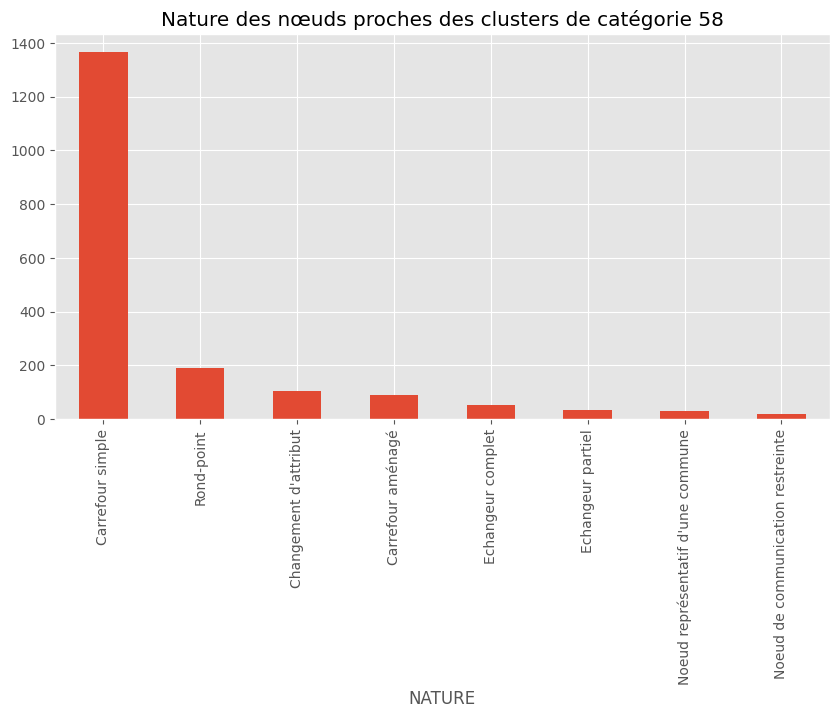

In [11]:
cn_58_graph = cross_node_58[cross_node_58['index_noeud'].notnull()]
_ = cn_58_graph.groupby("NATURE").size().reset_index(name='counts').sort_values(by="counts", ascending=False).plot.bar(
    x="NATURE", y="counts", 
    legend=False, figsize=(10,5),
    title="Nature des nœuds proches des clusters de catégorie 58")

### 2.2 - Croisement points verts 60

In [12]:
cross_node_60 = gpd.sjoin_nearest(
    gdf_60_2154,
    noeud_routier_2154,
    how="left",
    max_distance=50,
    lsuffix="velo",
    rsuffix="noeud",
    distance_col="dist_m"
)

In [13]:
print(f"Nombre de lignes avant jointure : {gdf_60_2154.shape[0]}")
print(f"Nombre de lignes après jointure : {cross_node_60[cross_node_60['index_noeud'].notnull()].shape[0]}")

Nombre de lignes avant jointure : 930
Nombre de lignes après jointure : 418


In [14]:
cn_60_graph = cross_node_60[cross_node_60['index_noeud'].notnull()].shape[0]

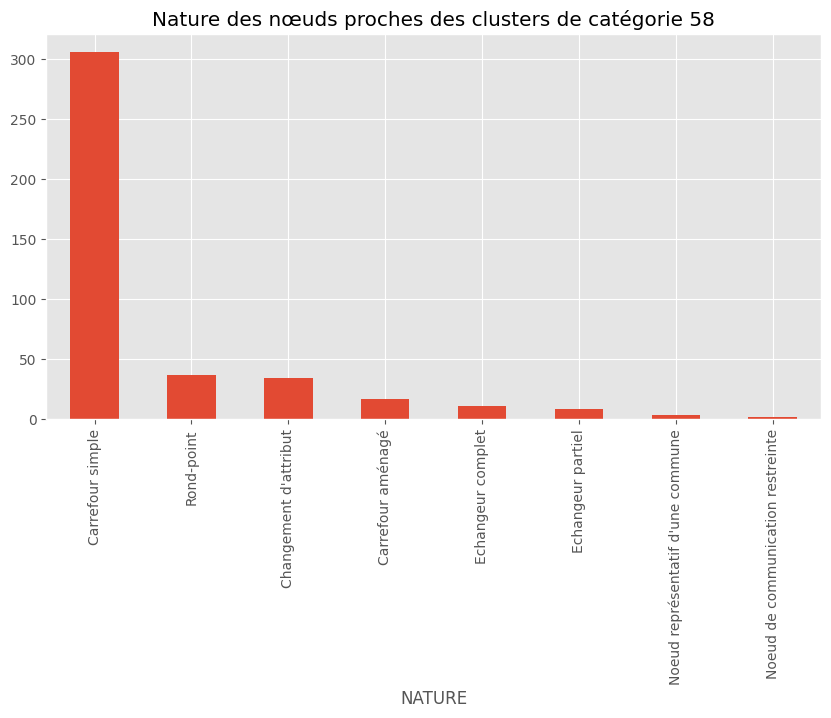

In [15]:
cn_60_graph = cross_node_60[cross_node_60['index_noeud'].notnull()]
_ = cn_60_graph.groupby("NATURE").size().reset_index(name='counts').sort_values(by="counts", ascending=False).plot.bar(
    x="NATURE", y="counts", 
    legend=False, figsize=(10,5),
    title="Nature des nœuds proches des clusters de catégorie 58")

## Export des données

In [16]:
cn_58 = cross_node_58[cross_node_58['index_noeud'].notnull()]
cn_58_export = cn_58[["cluster_id", "cat", "nb_points", "NATURE", "dist_m"]].sort_values(by="dist_m", ascending=False)
cn_58_export.head()

,cluster_id,cat,nb_points,NATURE,dist_m
1488,1488,58,27,Carrefour simple,49.913587
1708,1708,58,20,Carrefour simple,49.124234
891,891,58,21,Echangeur partiel,48.724598
1638,1638,58,46,Carrefour simple,48.667017
2381,2381,58,16,Carrefour simple,48.502660


In [17]:
cn_60 = cross_node_60[cross_node_60['index_noeud'].notnull()]
cn_60_export = cn_60[["cluster_id", "cat", "nb_points", "NATURE", "dist_m"]].sort_values(by="dist_m", ascending=False)
cn_60_export.head()

,cluster_id,cat,nb_points,NATURE,dist_m
665,665,60,29,Carrefour simple,49.060308
884,884,60,15,Carrefour simple,48.409307
38,38,60,18,Changement d'attribut,48.376809
21,21,60,32,Carrefour simple,47.681892
717,717,60,23,Carrefour simple,47.620371


In [18]:
cn_58_export.to_excel("temp/croisement_noeuds_58.xlsx", index=False)
cn_60_export.to_excel("temp/croisement_noeuds_60.xlsx", index=False)

-- END --